### OCR Demo

In [1]:
import os
import cv2

from glob import glob
from tqdm import tqdm
from pathlib import Path
from natsort import natsorted

from BDRC.data import OpStatus
from BDRC.exporter import JsonExporter, PageXMLExporter, TextExporter
from BDRC.inference import OCRPipeline

from BDRC.utils import show_image, create_dir, get_filename, read_line_model_config, read_layout_model_config, read_ocr_model_config, save_ocr_lines_parquet

In [3]:
data_path = "Data/W2PD17487-v2"
output_dir = os.path.join(data_path, "Output")
create_dir(output_dir)

xml_exporter = PageXMLExporter(output_dir)
json_exporter = JsonExporter(output_dir)
text_exporter = TextExporter(output_dir)

img_ext = "jpg"
image_paths = natsorted(glob(f"{data_path}/*.{img_ext}"))

print(f"Images: {len(image_paths)}")

Images: 784


(472, 2550, 3)
Data/W2PD17487-v2\I4PD9100008.jpg
I4PD9100008


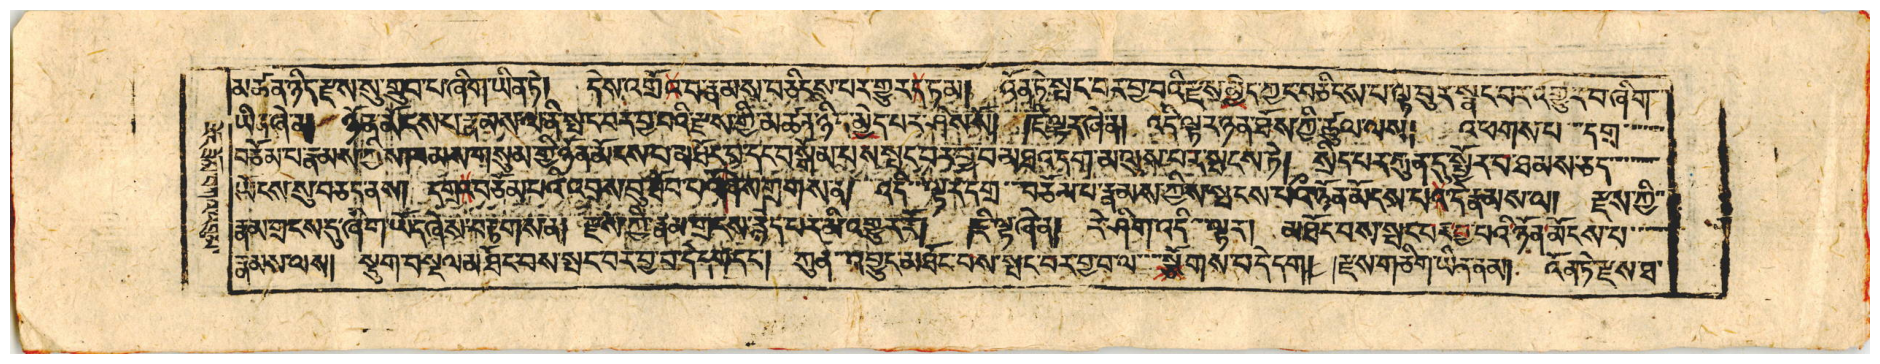

In [4]:
idx = 3
img = cv2.imread(image_paths[idx], cv2.IMREAD_COLOR_RGB)
print(img.shape)
print(image_paths[idx])
image_name = get_filename(image_paths[idx])
print(image_name)
show_image(img)

#### OCR via Pipelines using a line or layout model

In [5]:
# run download_al_models.py to download models and configs from HuggingFace
line_model_config_file = "Models/BDRC/PhotiLines_v2/config.json"
layout_model_config_file = "Models/BDRC/Photi-v2/config.json"

line_model_config = read_line_model_config(line_model_config_file)
layout_model_config = read_layout_model_config(layout_model_config_file)
#modern_layout_model_config = read_layout_model_config(modern_layout_config_file)

In [6]:
# OCR pipeline with woodblock mdoel and layout model
ocr_model_config_file = "Models/BDRC/Woodblock/model_config.json"
#ocr_model_config_file = "Models/BDRC/BigUCHAN_v1/config.json"
ocr_model_config = read_ocr_model_config(ocr_model_config_file)
ocr_pipeline = OCRPipeline(ocr_model_config, layout_model_config, kenlm_config=None)

Available ONNX providers: ['AzureExecutionProvider', 'CPUExecutionProvider']
Available ONNX providers: ['AzureExecutionProvider', 'CPUExecutionProvider']


In [7]:
status, result = ocr_pipeline.run_ocr(img, k_factor=2.0, bbox_tolerance=2.5, eval_mode=False)
print(status)

OpStatus.SUCCESS


In [9]:
if status == OpStatus.SUCCESS:
    rot_mask, sorted_lines, ocr_lines, page_angle = result

In [10]:
# debug ocr_lines
ocr_lines

[OCRLine(guid=UUID('35b08be3-f884-11f0-8017-a314e6dbf054'), text='མཚན་ཉིད་རྫས་སུ་གྲུབ་པ་ཞིག་ཡིན་ཏེ།དེས་འགྲོས་པ་རྣམས་བཅིངས་པར་གྱུརད་ཏམ།ཉོན་ཏྟེ་སྤང་བར་བྱ་བའི་རྫས་ཀྱིད་ཀྱང་བཅིངས་པ་ལྟ་བུར་སྤོང་བར་འགྱུར་པབ་ཞིག་', encoding='UNICODE', ctc_conf=None, logits=None, lm_scores=None),
 OCRLine(guid=UUID('35b08be2-f884-11f0-8017-a314e6dbf054'), text='ཡིན་ཞེ་ན།ཉོན་མོངས་པ་རྣམས་ལ་ནི་སྤང་བར་བྱ་བའི་རྫས་ཀྱི་མཚན་ཉིད་མྱེད་པར་ཤིས་སོ།ཇི་ལྟར་ཞེ་ན།འདི་ལྟར་ཉན་ཐོས་ཀྱི་ཚུལ་ལས།འཕགས་པ་དགྲ་', encoding='UNICODE', ctc_conf=None, logits=None, lm_scores=None),
 OCRLine(guid=UUID('35b08be1-f884-11f0-8017-a314e6dbf054'), text='བཅོམ་པ་རྣམས་ཀྱིས་ཁམས་གསུམ་གྱི་ཉོན་མོངས་པ་མཐོར་བྱ་དང་བསྒོམ་པས་སྤང་བར་བྱ་བ་མཐའ་དག་མ་ལུས་པར་ཡངས་ཏེ།སྲིད་པར་ཀུན་དུ་སྦྱོར་བ་ཐམས་ཅད་', encoding='UNICODE', ctc_conf=None, logits=None, lm_scores=None),
 OCRLine(guid=UUID('35b08be0-f884-11f0-8017-a314e6dbf054'), text='ཡོངས་སུ་བཅད་ནས།དགྲར་བཅོམ་པའི་འབྲས་བུ་ཐོབ་པའོ་ཞེས་གྲགས་ན།འདི་ལྷར་དགྲ་བཅོམ་པ་རྣམས་ཀྱིས་སྤངས་པའི་ཉོན་མོངས་པའི་དེ་རྣམས་ལ།རྫས་ཀྱི་', encoding='UNICO

In [10]:
# save parquet
parq_out = f"Data/{image_name}.parquet"
save_ocr_lines_parquet(ocr_lines, parq_out)

#### Single Volume

In [ ]:
# single volume
data_path = "Data/W22273-v2"
output_dir = os.path.join(data_path, "Output")
create_dir(output_dir)

text_exporter = TextExporter(output_dir)
xml_exporter = PageXMLExporter(output_dir)

img_ext = "png"
image_paths = natsorted(glob(f"{data_path}/*.{img_ext}"))

if len(image_paths) > 0:
    for idx, image_path in tqdm(enumerate(image_paths), total=len(image_paths)):
        image_name = get_filename(image_path)

        page_name = os.path.basename(image_path)
        base = os.path.splitext(page_name)[0]
        img = cv2.imread(image_path)
        status, ocr_result = ocr_pipeline.run_ocr(img, k_factor=2.0, bbox_tolerance=2.5, eval_mode=True)
        
        if status == OpStatus.SUCCESS:
            _, lines, ocr_lines, angle = ocr_result
            if len(ocr_lines) > 0:
                xml_exporter.export_lines(img, base, lines, ocr_lines, angle=angle)
                text_exporter.export_lines(img, base, lines, ocr_lines)

                parq_out = f"{output_dir}/{image_name}.parquet"
                save_ocr_lines_parquet(ocr_lines, parq_out)

100%|██████████| 10/10 [00:19<00:00,  1.94s/it]


#### Run Multiple Volumes

In [ ]:
# run on all data
ocr_model_config_file = "Models/BDRC/BigUCHAN_v1/config.json"
ocr_model_config = read_ocr_model_config(ocr_model_config_file)

work_id = "W22081_all"
root_dir = "C:/Users/Eric/Downloads/W22081_all"

output_dir = os.path.join(root_dir, "Output")
create_dir(output_dir)

ocr_pipeline = OCRPipeline(ocr_model_config, line_model_config, False)

for sub_dir in Path(root_dir).iterdir():
    if sub_dir.name == "Output":
        continue
    
    if f"{work_id}" in str(sub_dir) and os.path.isdir(sub_dir):

        volume_out = os.path.join(output_dir, str(sub_dir.name))

        if os.path.exists(volume_out):
            continue

        create_dir(volume_out)
        print(volume_out)
        text_exporter = TextExporter(volume_out)
        xml_exporter = PageXMLExporter(volume_out)

        img_ext = "tif"
        image_paths = natsorted(glob(f"{sub_dir}/*.{img_ext}"))
        print(f"{sub_dir.name} => Images: {len(image_paths)}")

        if len(image_paths) > 0:
            for idx, image_path in tqdm(enumerate(image_paths), total=len(image_paths)):
                page_name = os.path.basename(image_path)
                base = os.path.splitext(page_name)[0]
                img = cv2.imread(image_path)
                status, ocr_result = ocr_pipeline.run_ocr(img, k_factor=2.0, bbox_tolerance=2.5)

                if status == OpStatus.SUCCESS:
                    _, lines, ocr_lines, angle = ocr_result
                    if len(ocr_result[2]) > 0:
                        xml_exporter.export_lines(img, base, lines, ocr_lines, angle=angle)
                        text_exporter.export_lines(img, base, lines, ocr_lines)